In [3]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd;
import seaborn as sns
from sklearn.externals import joblib
from tqdm import tqdm_notebook as tqdm
import warnings

warnings.filterwarnings('ignore')

DIR = '../data/raw/'
NROWS = 100000

/home/kuba/programs/miniconda3/envs/py_36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
X = pd.read_csv(os.path.join(DIR,'application_train.csv.zip'), nrows=NROWS)
display(X.head())

display(X.shape)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


(100000, 122)

Ok, not a huge dataset with 300k rows and 122 columns. Not everything is a feature though.

# Target
Let's take a look at the target distribution.

In [3]:
X['TARGET'].mean()

0.08093

Ok so we are dealing with imbalanced dataset.

# Features

## Columns
Let's see which columns can be used as features.

In [4]:
desc = pd.read_csv(os.path.join(DIR, 'HomeCredit_columns_description.csv'), encoding='latin-1')
desc.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [5]:
desc[(desc['Row'].isin(X.columns[:22])) & 
     (desc['Table']=='application_{train|test}.csv')][['Row','Description','Special']]

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,Target variable (1 - client with payment diffi...,NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,CNT_CHILDREN,Number of children the client has,NaN
7,AMT_INCOME_TOTAL,Income of the client,NaN
8,AMT_CREDIT,Credit amount of the loan,NaN
9,AMT_ANNUITY,Loan annuity,NaN


In [6]:
desc[(desc['Row'].isin(X.columns[22:72])) & 
     (desc['Table']=='application_{train|test}.csv')][['Row','Description','Special']]

,Row,Description,Special
22,FLAG_MOBIL,"Did client provide mobile phone (1=YES, 0=NO)",NaN
23,FLAG_EMP_PHONE,"Did client provide work phone (1=YES, 0=NO)",NaN
24,FLAG_WORK_PHONE,"Did client provide home phone (1=YES, 0=NO)",NaN
25,FLAG_CONT_MOBILE,"Was mobile phone reachable (1=YES, 0=NO)",NaN
26,FLAG_PHONE,"Did client provide home phone (1=YES, 0=NO)",NaN
27,FLAG_EMAIL,"Did client provide email (1=YES, 0=NO)",NaN
28,OCCUPATION_TYPE,What kind of occupation does the client have,NaN
29,CNT_FAM_MEMBERS,How many family members does client have,NaN
30,REGION_RATING_CLIENT,Our rating of the region where client lives (1...,NaN
31,REGION_RATING_CLIENT_W_CITY,Our rating of the region where client lives wi...,NaN


In [7]:
desc[(desc['Row'].isin(X.columns[72:])) & 
     (desc['Table']=='application_{train|test}.csv')][['Row','Description','Special']]

,Row,Description,Special
72,APARTMENTS_MEDI,Normalized information about building where th...,normalized
73,BASEMENTAREA_MEDI,Normalized information about building where th...,normalized
74,YEARS_BEGINEXPLUATATION_MEDI,Normalized information about building where th...,normalized
75,YEARS_BUILD_MEDI,Normalized information about building where th...,normalized
76,COMMONAREA_MEDI,Normalized information about building where th...,normalized
77,ELEVATORS_MEDI,Normalized information about building where th...,normalized
78,ENTRANCES_MEDI,Normalized information about building where th...,normalized
79,FLOORSMAX_MEDI,Normalized information about building where th...,normalized
80,FLOORSMIN_MEDI,Normalized information about building where th...,normalized
81,LANDAREA_MEDI,Normalized information about building where th...,normalized


Some **obviously** interesting columns are:
* type of contract: 
    * cols[:22] NAME_CONTRACT_TYPE
* client BIO information: 
    * cols[:22] CODE_GENDER, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, DAYS_BIRTH, CNT_CHILDREN 
    * cols[22:72] CNT_FAM_MEMBERS
* client ownership info: FLAG_OWN_CAR, FLAG_OWN_REALTY
* client income/employment info: 
    * cols[:22] AMT_INCOME_TOTAL, NAME_INCOME_TYPE, DAYS_EMPLOYED
    * cols[22:72] OCCUPATION_TYPE, ORGANIZATION_TYPE
* loan info: 
    * cols[:22] AMT_CREDIT, AMT_ANNUITY
    * cols[72:] AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR
* external ratings:
    * cols[22:72] EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3
    
It doesn't mean that those are the only ones but let's look at them first.

In [8]:
FEATURE_COLUMNS_APPLICATION_V1 = ['NAME_CONTRACT_TYPE',
                                  'CODE_GENDER', 
                                  'NAME_EDUCATION_TYPE',                                   
                                  'NAME_FAMILY_STATUS', 
                                  'NAME_HOUSING_TYPE', 
                                  'DAYS_BIRTH', 
                                  'CNT_CHILDREN',
                                  'CNT_FAM_MEMBERS',
                                  'FLAG_OWN_CAR',
                                  'FLAG_OWN_REALTY',
                                  'AMT_INCOME_TOTAL', 
                                  'NAME_INCOME_TYPE', 
                                  'DAYS_EMPLOYED',
                                  'OCCUPATION_TYPE', 
                                  'ORGANIZATION_TYPE',
                                  'AMT_CREDIT', 
                                  'AMT_ANNUITY',
                                  'AMT_REQ_CREDIT_BUREAU_HOUR', 
                                  'AMT_REQ_CREDIT_BUREAU_DAY', 
                                  'AMT_REQ_CREDIT_BUREAU_WEEK', 
                                  'AMT_REQ_CREDIT_BUREAU_QRT', 
                                  'AMT_REQ_CREDIT_BUREAU_YEAR',
                                  'EXT_SOURCE_1', 
                                  'EXT_SOURCE_2', 
                                  'EXT_SOURCE_3'
                                 ]

display(X[FEATURE_COLUMNS_APPLICATION_V1].head())
display(X[FEATURE_COLUMNS_APPLICATION_V1].describe())

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,CNT_CHILDREN,CNT_FAM_MEMBERS,FLAG_OWN_CAR,FLAG_OWN_REALTY,...,AMT_CREDIT,AMT_ANNUITY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,Cash loans,M,Secondary / secondary special,Single / not married,House / apartment,-9461,0,1.0,N,Y,...,406597.5,24700.5,0.0,0.0,0.0,0.0,1.0,0.083037,0.262949,0.139376
1,Cash loans,F,Higher education,Married,House / apartment,-16765,0,2.0,N,N,...,1293502.5,35698.5,0.0,0.0,0.0,0.0,0.0,0.311267,0.622246,NaN
2,Revolving loans,M,Secondary / secondary special,Single / not married,House / apartment,-19046,0,1.0,Y,Y,...,135000.0,6750.0,0.0,0.0,0.0,0.0,0.0,NaN,0.555912,0.729567
3,Cash loans,F,Secondary / secondary special,Civil marriage,House / apartment,-19005,0,2.0,N,Y,...,312682.5,29686.5,NaN,NaN,NaN,NaN,NaN,NaN,0.650442,NaN
4,Cash loans,M,Secondary / secondary special,Single / not married,House / apartment,-19932,0,1.0,N,Y,...,513000.0,21865.5,0.0,0.0,0.0,0.0,0.0,NaN,0.322738,NaN


,DAYS_BIRTH,CNT_CHILDREN,CNT_FAM_MEMBERS,AMT_INCOME_TOTAL,DAYS_EMPLOYED,AMT_CREDIT,AMT_ANNUITY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,100000.000000,100000.000000,99999.000000,1.000000e+05,100000.000000,1.000000e+05,99993.000000,86563.000000,86563.000000,86563.000000,86563.000000,86563.000000,43717.000000,9.978500e+04,80173.000000
mean,-16026.453260,0.417390,2.155672,1.694261e+05,63292.222060,5.990034e+05,27085.325928,0.006631,0.007347,0.033929,0.266026,1.892032,0.502970,5.142005e-01,0.510413
std,4368.307878,0.721014,0.908897,3.835007e+05,140839.697296,4.020520e+05,14459.617534,0.085864,0.107338,0.204085,0.613759,1.876002,0.211463,1.915273e-01,0.195063
min,-25201.000000,0.000000,1.000000,2.565000e+04,-17531.000000,4.500000e+04,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014568,8.173617e-08,0.000527
25%,-19668.000000,0.000000,2.000000,1.125000e+05,-2758.000000,2.700000e+05,16456.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.334218,3.916287e-01,0.368969
50%,-15742.000000,0.000000,2.000000,1.440000e+05,-1219.000000,5.130405e+05,24903.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.507710,5.663911e-01,0.535276
75%,-12390.750000,1.000000,3.000000,2.025000e+05,-291.000000,8.086500e+05,34596.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.675874,6.641880e-01,0.669057
max,-7676.000000,12.000000,14.000000,1.170000e+08,365243.000000,4.050000e+06,258025.500000,3.000000,6.000000,8.000000,8.000000,25.000000,0.951624,8.549997e-01,0.896010


In [9]:
X['AMT_REQ_CREDIT_BUREAU_HOUR'].head()

0    0.0
1    0.0
2    0.0
3    NaN
4    0.0
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64

In [10]:
FEATURE_COLUMNS_APPLICATION_V1_CATEGORICAL = ['NAME_CONTRACT_TYPE',
                                  'CODE_GENDER', 
                                  'NAME_EDUCATION_TYPE',                                   
                                  'NAME_FAMILY_STATUS', 
                                  'NAME_HOUSING_TYPE', 
                                  'FLAG_OWN_CAR',
                                  'FLAG_OWN_REALTY',
                                  'NAME_INCOME_TYPE', 
                                  'OCCUPATION_TYPE', 
                                  'ORGANIZATION_TYPE',
                                 ]

FEATURE_COLUMNS_APPLICATION_V1_NUMERIC = list(set(FEATURE_COLUMNS_APPLICATION_V1) \
                                              - set(FEATURE_COLUMNS_APPLICATION_V1_CATEGORICAL))

## Missing Values
Let's look at the missing values fraction for those columns:

In [11]:
X[FEATURE_COLUMNS_APPLICATION_V1].isnull().sum()/len(X)

NAME_CONTRACT_TYPE            0.00000
CODE_GENDER                   0.00000
NAME_EDUCATION_TYPE           0.00000
NAME_FAMILY_STATUS            0.00000
NAME_HOUSING_TYPE             0.00000
DAYS_BIRTH                    0.00000
CNT_CHILDREN                  0.00000
CNT_FAM_MEMBERS               0.00001
FLAG_OWN_CAR                  0.00000
FLAG_OWN_REALTY               0.00000
AMT_INCOME_TOTAL              0.00000
NAME_INCOME_TYPE              0.00000
DAYS_EMPLOYED                 0.00000
OCCUPATION_TYPE               0.31224
ORGANIZATION_TYPE             0.00000
AMT_CREDIT                    0.00000
AMT_ANNUITY                   0.00007
AMT_REQ_CREDIT_BUREAU_HOUR    0.13437
AMT_REQ_CREDIT_BUREAU_DAY     0.13437
AMT_REQ_CREDIT_BUREAU_WEEK    0.13437
AMT_REQ_CREDIT_BUREAU_QRT     0.13437
AMT_REQ_CREDIT_BUREAU_YEAR    0.13437
EXT_SOURCE_1                  0.56283
EXT_SOURCE_2                  0.00215
EXT_SOURCE_3                  0.19827
dtype: float64

It's not bad at all. Only for the OCCUPATION_TYPE, EXT_SOURCE_1 and EXT_SOURCE_3 those values are larger than 10%.
I am planning on using lightGBM which deals with NAs so let's leave those columns as they are.

## Outliers

Let's look for outliers.

First numerical columns:

In [27]:
X=X.sample(1000)

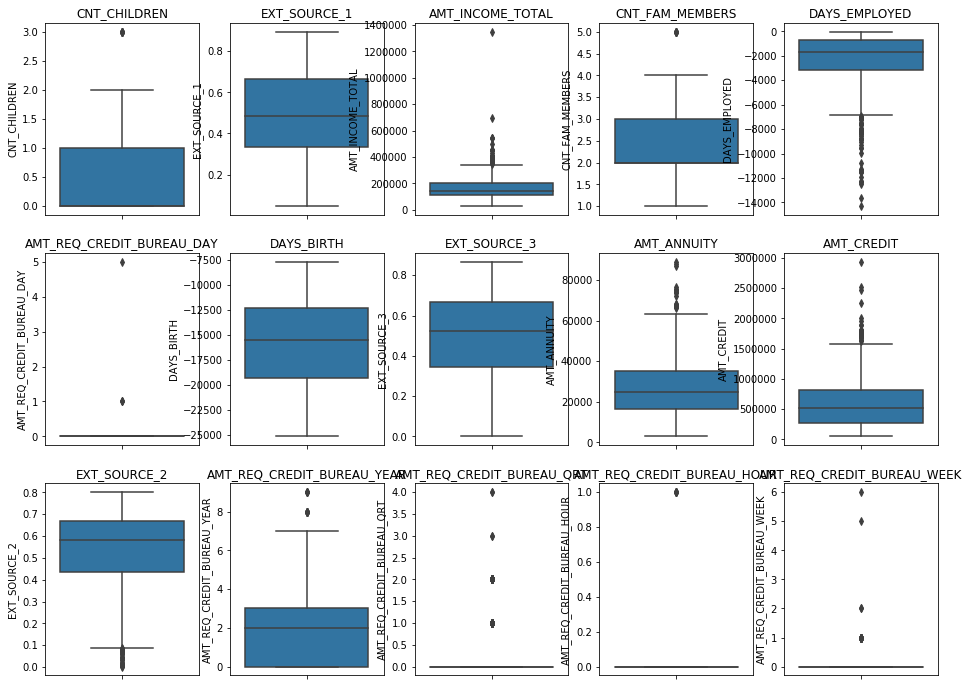

In [28]:
fig, axs = plt.subplots(3,5, figsize=(16,12))
for i, col in enumerate(FEATURE_COLUMNS_APPLICATION_V1_NUMERIC):
    x_pos, y_pos = i//5, i%5
    sns.boxplot(y=col, data=X, ax=axs[x_pos, y_pos]).set_title(col)
plt.show()

It seems that there could be outliers in:
* CNT_CHILDREN and CNT_FAM_MEMBERS but those could be just large families
* AMT_REQ_CREDIT_BUREAU{} but maybe some people just made a lot of requests
* DAYS_EMPLOYED 350000 is 960 years so it **must be** outlier
* AMT_INCOME_TOTAL we have some really high earners :) or outlier

Let's take a look at those outliers.

In [14]:
long_employment = X[X['DAYS_EMPLOYED'] > 10000][['DAYS_EMPLOYED']]
display(long_employment.head())
display(long_employment.shape)
display(long_employment.nunique())

,DAYS_EMPLOYED
8,365243
11,365243
23,365243
38,365243
43,365243


(17865, 1)

DAYS_EMPLOYED    1
dtype: int64

It seems that NA in DAYS_EMPLOYED is encoded as a value 365243.

In [15]:
large_families = X[(X['CNT_CHILDREN']> 10) | 
                   (X['CNT_FAM_MEMBERS'] > 15)][['CNT_FAM_MEMBERS', 'CNT_CHILDREN']]
display(large_families.head())
display(large_families.shape)
display(large_families.nunique())

,CNT_FAM_MEMBERS,CNT_CHILDREN
34545,13.0,11
80948,14.0,12


(2, 2)

CNT_FAM_MEMBERS    2
CNT_CHILDREN       2
dtype: int64

It could just be a few very large families. I will leave it for now.
Now let's look at the categorical features:

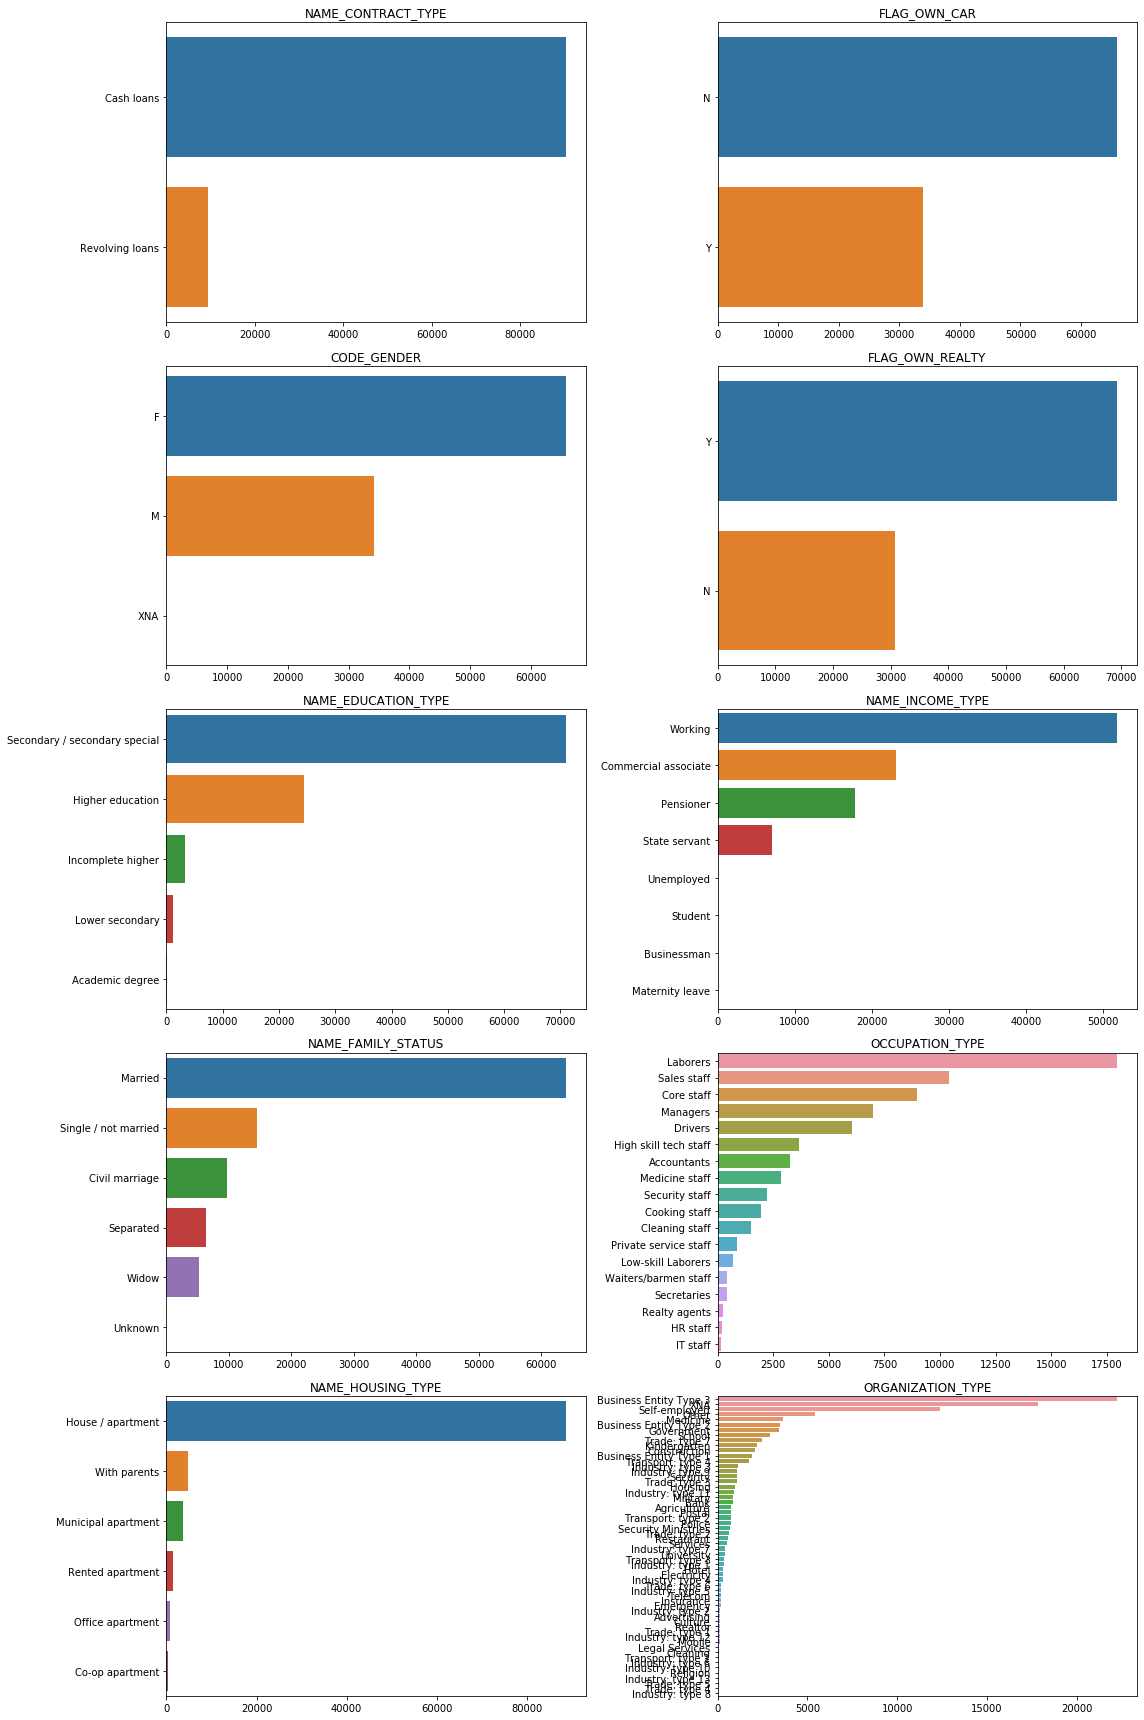

In [16]:
fig, axs = plt.subplots(5,2, figsize=(16,24))
for i, col in enumerate(FEATURE_COLUMNS_APPLICATION_V1_CATEGORICAL):
    y_pos, x_pos = i//5, i%5
    counts = X[col].value_counts()
    sns.barplot(counts.values, counts.index, ax=axs[x_pos, y_pos]).set_title(col)
plt.tight_layout()
plt.show()

We can see that:
* CODE_GENDER has a third level XNA which is encoding of missing value
* ORGANIZATION_TYPE has a lot of levels and can be potentially split to 2 levels and also has missing value encoded with XNA

In [17]:
X['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    22269
XNA                       17865
Self-employed             12362
Other                      5428
Medicine                   3654
Business Entity Type 2     3464
Government                 3394
School                     2914
Trade: type 7              2478
Kindergarten               2216
Construction               2100
Business Entity Type 1     1940
Transport: type 4          1723
Industry: type 3           1108
Industry: type 9           1096
Security                   1091
Trade: type 3              1090
Housing                     986
Industry: type 11           940
Military                    872
Bank                        866
Agriculture                 764
Postal                      734
Transport: type 2           726
Police                      720
Security Ministries         682
Trade: type 2               628
Restaurant                  584
Services                    544
Industry: type 7            429
University                  419
Transpor

Ok we can proceed to the first iteration of data cleaning and feature engineering.

# Data Cleaning

In [18]:
def clean_application_table(X, numerical_columns):
    X[numerical_columns] = X[numerical_columns].astype(float)
    X['DAYS_EMPLOYED'] = X['DAYS_EMPLOYED'].replace(365243, np.nan)
    X['CODE_GENDER'] = X['CODE_GENDER'].replace('XNA', np.nan)
    X['ORGANIZATION_TYPE'] = X['ORGANIZATION_TYPE'].replace('XNA', np.nan)
    return X

X = clean_application_table(X, FEATURE_COLUMNS_APPLICATION_V1_NUMERIC)
X.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Engineering

Let's take the features we found and construct some new features from them.

First let's encode the categorical variables.

In [19]:
import swifter

def split_organization_type(X):
    organization_cols = ['ORGANIZATION_TYPE_main','ORGANIZATION_TYPE_subtype']

    def _split_org(x):
        x = str(x).replace(':','')
        split_types = x.lower().split('type')
        if len(split_types) == 1:
            return pd.Series({'ORGANIZATION_TYPE_main':split_types[0],
                              'ORGANIZATION_TYPE_subtype':np.nan})
        else:
            return pd.Series({'ORGANIZATION_TYPE_main':split_types[0],
                              'ORGANIZATION_TYPE_subtype':split_types[1]})

    X[organization_cols] = X['ORGANIZATION_TYPE'].swifter.apply(_split_org)
    
    return X, organization_cols

In [20]:
def hand_crafted_features_application_table(X):
    X['annuity_income_percentage'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
    X['children_ratio'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']
    X['credit_to_annuity_ratio'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
    X['credit_to_income_ratio'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
    X['days_employed_percentage'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
    X['income_credit_percentage'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
    X['income_per_child'] = X['AMT_INCOME_TOTAL'] / (1 + X['CNT_CHILDREN'])
    X['income_per_person'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
    X['payment_rate'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
    
    X, organization_cols = split_organization_type(X)
    
    hand_crafted_columns = ['annuity_income_percentage',
                           'children_ratio',
                           'credit_to_annuity_ratio',
                           'credit_to_income_ratio',
                           'days_employed_percentage',
                           'income_credit_percentage',
                           'income_per_child',
                           'income_per_person',
                           'payment_rate',
                          ]
    
    return X, hand_crafted_columns + organization_cols

X, hand_crafted_columns = hand_crafted_features_application_table(X)
print(hand_crafted_columns)
X.head()


['annuity_income_percentage', 'children_ratio', 'credit_to_annuity_ratio', 'credit_to_income_ratio', 'days_employed_percentage', 'income_credit_percentage', 'income_per_child', 'income_per_person', 'payment_rate', 'ORGANIZATION_TYPE_main', 'ORGANIZATION_TYPE_subtype']


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,children_ratio,credit_to_annuity_ratio,credit_to_income_ratio,days_employed_percentage,income_credit_percentage,income_per_child,income_per_person,payment_rate,ORGANIZATION_TYPE_main,ORGANIZATION_TYPE_subtype
0,100002,1,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,0.0,16.461104,2.007889,0.067329,0.498036,202500.0,202500.0,0.060749,business entity,3
1,100003,0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,0.0,36.234085,4.790750,0.070862,0.208736,270000.0,135000.0,0.027598,school,NaN
2,100004,0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,0.0,20.000000,2.000000,0.011814,0.500000,67500.0,67500.0,0.050000,government,NaN
3,100006,0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,0.0,10.532818,2.316167,0.159905,0.431748,135000.0,67500.0,0.094941,business entity,3
4,100007,0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,0.0,23.461618,4.222222,0.152418,0.236842,121500.0,121500.0,0.042623,religion,NaN


In [21]:
from sklearn.preprocessing import LabelEncoder

def encode_categoricals_application_table(X, columns):
    for col in columns:
        X[col] = LabelEncoder.fit_transform(X[col].astype(str), y=X[col].astype(str))
    return X

X = encode_categoricals_application_table(X, FEATURE_COLUMNS_APPLICATION_V1_CATEGORICAL)

In [22]:
ALL_FEATURE_COLUMNS = hand_crafted_columns + FEATURE_COLUMNS_APPLICATION_V1
TARGET_COLUMNS = ['TARGET']
ID_COLUMNS = ['SK_ID_CURR']

In [23]:
ALL_FEATURE_COLUMNS

['annuity_income_percentage',
 'children_ratio',
 'credit_to_annuity_ratio',
 'credit_to_income_ratio',
 'days_employed_percentage',
 'income_credit_percentage',
 'income_per_child',
 'income_per_person',
 'payment_rate',
 'ORGANIZATION_TYPE_main',
 'ORGANIZATION_TYPE_subtype',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'DAYS_EMPLOYED',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3']

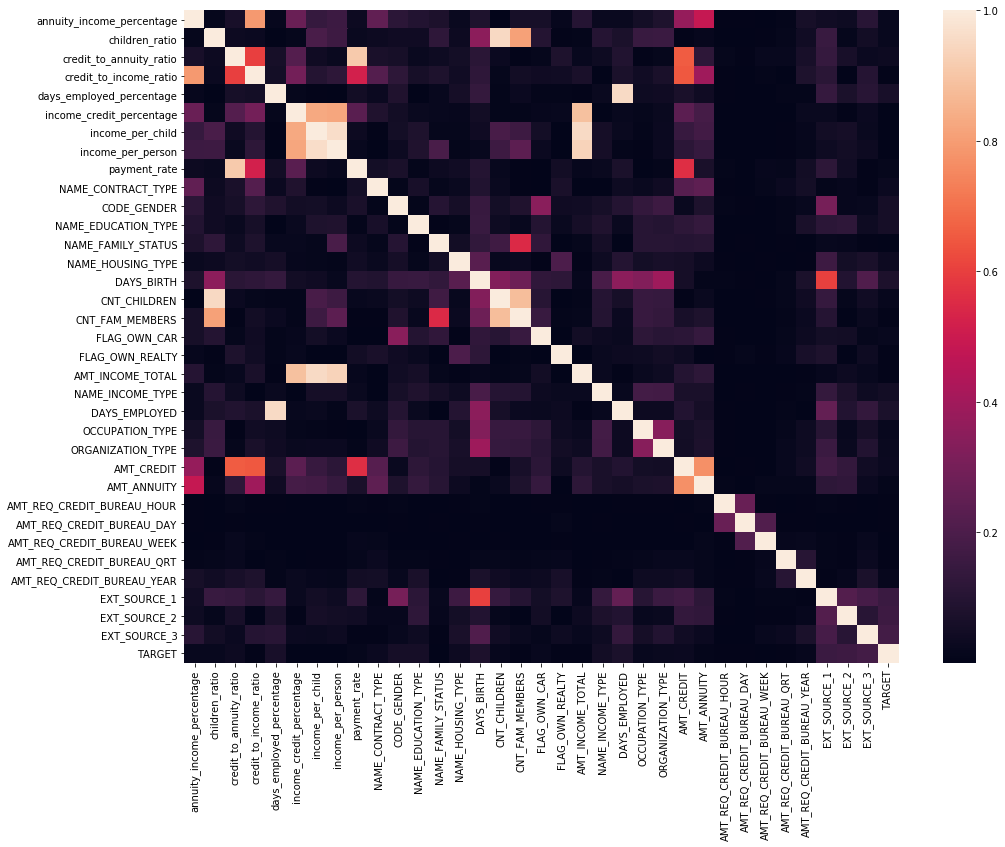

In [24]:
X_corr = abs(X[ALL_FEATURE_COLUMNS+TARGET_COLUMNS].corr())
X_corr.sort_values('TARGET', ascending=False)['TARGET']

plt.figure(figsize=(16,12))
sns.heatmap(X_corr, 
            xticklabels=X_corr.columns,
            yticklabels=X_corr.columns)

Let's create those features as **application_table_features_v1.0**